In [517]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [306]:
# In order to have a wider notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Class MLP
This class lets you build a simple Multi-Layer perceptron (MLP) with just one hidden layer.

The class should be used in the following way:  
first, create an instance
```python
mlp = MLP()
```
then, initialize the class, specifying the characteristics of the network you want
```python
mlp.initialize(NI=5, NH=3, NO=1, activation_h=sigmoid, activation_o=linear)
```
with this call, the network is initialized with 5 input units, 3 units on the (only) hidden layer, and one unit on the output layer. In addition to that, the network will use a sigmoid activation function on the hidden units and a linear activation function on the output unit.  
Then you can finally train the network:
```python
mlp.train(X, y, n_epochs, batch_size, learning_rate, X_test=None, y_test=None)
```
the usage of all the parameters should be straightforward; if you include a test set, this will be used in order to compare its error with the error of the network on the train set.  
Once trained, calling
```python
mlp.predict(p)
```
will give you the prediction of the network on the given input point


## Activation Functions

In the following cells, the (supported) activation functions are defined. Each activation function is defined as a class so that calling:
```python
activation.f(x)
```
yelds the output of the function for the input x, and calling:
```python
activation.d_f(x)
```
yelds the output of the derivative of the function for the input x.  

In [2]:
class sigmoid:
    def f(x):
        return 1/(1+np.exp(-x))
    def d_f(x):
        return sigmoid.f(x)*(1-sigmoid.f(x))

In [3]:
class linear:
    def f(x):
        return x
    def d_f(x):
        return 1

In [4]:
class tanh:
    def f(x):
        return np.tanh(x)
    def d_f(x):
        return 1-tanh.f(x)**2

## Error Function
For this implementation, the function mean squared error is used as a loss function.  
it is computed as $$\frac{1}{2}\sum_{i=1}^{|t|} (t_i - y_i)^2$$
where $t$ is the target vector and $y$ is the prediction of the network.

In [5]:
def mse(t, y):
        return 0.5 * sum([(v[0]-v[1])**2 for v in zip(t, y)])

## Variables and Conventions 
The (main) variables used throughout the class are the following:  
```python
NI = # Number of input units
NH = # Number of hidden units
NO = # Number of output units

W1 = # Weights connecting the hidden and the input layer, indexed W1[h, i] where h is the index of the hidden unit and i is the index of the input unit
W2 = # Weights connecting the output and the hidden layer, indexed W2[o, h]

dW1 = # Temporary store of the changes to be applied to the weights in W1
dW2 = # Temporary store of the changes to be applied to the weights in W2

H = # Last output of the hidden units 
O = # Last output of the output units

Z1 = # Last input of the hidden units (often called 'net')
Z2 = # Last input of the output units

activation_h = # Hidden layer activation function
activation_o = # Output layer activation function
```

Throughout the code, the same indexing convention of the book 'Pattern Recognition And Machine Learning' by <i>C. Bishop</i> is used (Neural Networks are covered in chapter 5). In short, the convention consists of indexing the units from $N$ to 1. This is straightforward in cases where biases are involved, in all the other cases the first position of the list (index 0) is initialized and left empty. Following this convention, the lists are iterated in reversed ordering, from the last to the first index.

## Backpropagation 
As in the book 'Pattern Recognition And Machine Learning' by <i>C. Bishop</i>, the backpropagation is carried out in the following way:  
first of all, the $\delta$'s of the output units are computed:
$$\delta_{o}=(t_o-y_o)\times activation'_{out}(net_o)$$
where $o$ is the index of the output unit.  
These values are then used in order to compute the $\delta$'s for the hidden units:
$$\delta_{h}=activation'_{hidden}(net_h) \times \sum_{o = 1}^{NO}W_{o, h}\delta_o$$
where $h$ is the index of the hidden unit.  
The derivatives with respect to the weight connecting the hidden and output layer are then computed as:
$$\frac{\partial}{\partial W_{o, h}}=\delta_o \times H_h$$
where $H_h$ is the last output of the hidden unit $h$. As regards the weights connecting the hidden layer to the input layer, they are computed as:
$$\frac{\partial}{\partial W_{h, i}}=\delta_h \times X_i$$
Then the weights are updated as:
$$W_{a, b} = W_{a, b} + \frac{\partial}{\partial W_{a, b}} * learning\_rate$$

In [703]:
class MLP:
    def initialize(self, NI, NH, NO, activation_h, activation_o):
        
        # Number of units per layer
        self.NI = NI
        self.NH = NH
        self.NO = NO
                
        # Activation functions
        self.activation_h = activation_h
        self.activation_o = activation_o
        
        # Random initialization of the weights (performs He initialization)
        self.W1 = np.random.randn(self.NH+1, self.NI +1)*np.sqrt(2/(self.NI+self.NH))
        self.W2 = np.random.randn(self.NO+1, self.NH +1)*np.sqrt(2/(self.NH+self.NO))
        
        # Variables storing the updates of the weights, waiting to be performed
        self.dW1 = np.zeros((self.NH+1, self.NI +1))
        self.dW2 = np.zeros((self.NO+1, self.NH +1))
        
        # Variables storing the input of the activation functions (nets) 
        # for the hidden layer (Z1) and for the output layer (Z2)
        self.Z1 = np.zeros(self.NH+1)
        self.Z2 = np.zeros(self.NO+1)
        
        # Variables storing the output of the activation functions
        self.H = np.ones(self.NH+1)
        self.O = np.ones(self.NO+1)
        
        # Variables storing the average error per epoch
        self.errors_train = []
        self.errors_testing = []
        
        # Variable counting the total amount of training epochs
        self.n_epochs = 0
        
        return
    
    def __forward__(self, I):
        
        # If the user inputs an np array, this is converted to a list
        # The field self.X stores the last input of the network
        try:
            self.X = I.tolist()
        except:
            self.X = I
        
        # For the bias, concatenates a 1 to the beginning of the input X
        self.X= [1] + self.X
        
        # Computes and stores the activations of the hidden layer
        for h in reversed(range(1, self.NH+1)):
            net = 0
            for i in reversed(range(0, self.NI+1)):
                net = net + self.X[i]*self.W1[h, i]
                
            self.Z1[h] = net
            self.H[h] = self.activation_h.f(net)
            
        # Computes and stores the activations of the output layer
        for o in reversed(range(1, self.NO+1)):
            net = 0
            for h in reversed(range(0, self.NH+1)):
                net = net + self.H[h]*self.W2[o, h]
            self.Z2[o] = net
            self.O[o] = self.activation_o.f(net)

        # Returns the outputs of the network
        return self.O[1:].copy()
    
    def __backwards__(self, t):
        
        # If the user inputs an np array, this is converted to a list
        # The field self.X stores the last input of the network
        try:
            self.target = t.tolist()
        except:
            self.target = t
            
        # Adds a 1 in the first position of the list in order to be consistent with 
        # the indexing convention
        self.target = [1] + self.target

        # Computes the deltas for the output layer
        deltas_out = [1]
        for o in range(1, self.NO+1):
            
            # Error = terget[i] - output[i]
            current_error = (self.target[o]-self.O[o])
            # Derivative = d/dx activation(net)
            derivative = self.activation_o.d_f(self.Z2[o])
            
            deltas_out.append(current_error * derivative)
        
        
        # Computes the deltas for the hidden units 
        deltas_hidden = []
        for h in reversed(range(1, self.NH+1)):
            
            # Computes the weighted sum delta_output[o]*weight[o, h]
            error = 0
            for o in reversed(range(1, self.NO+1)):
                error += (deltas_out[o] * self.W2[o, h])
            
            derivative = self.activation_h.d_f(self.Z1[h])
            deltas_hidden.append(derivative*error)
            
        # Adds 1 and reverses the list for indexing consistency
        deltas_hidden = list(reversed(deltas_hidden))
        deltas_hidden = [1] + deltas_hidden
                
        # computation of the weight changes
        for h in reversed(range(0, self.NH+1)):
            for o in reversed(range(1, self.NO+1)):
                self.dW2[o, h] = self.dW2[o, h] + (deltas_out[o]*self.H[h])
        for i in reversed(range(0, self.NI+1)):
            for h in reversed(range(1, self.NH+1)):
                self.dW1[h, i] = self.dW1[h, i] + (deltas_hidden[h]*self.X[i])      
                
        return mse(self.target, self.O)
                          
    def __update_weights__(self, learning_rate):
        
        # h iterates over the hidden units, i over the input units
        for h in reversed(range(1, self.NH+1)):
            for i in reversed(range(0, self.NI+1)):
                
                update = (learning_rate * self.dW1[h, i])
                self.W1[h, i] += update
                
        for o in reversed(range(1, self.NO+1)):
            for h in reversed(range(0, self.NH+1)):
                          
                update = (learning_rate * self.dW2[o, h])
                self.W2[o, h] += update
                
        self.__initialize_weight_updates__()
        return
    
    def __initialize_weight_updates__(self):
        self.dW1 = np.zeros((self.NH+1, self.NI +1))
        self.dW2 = np.zeros((self.NO+1, self.NH +1))
        return
    
    def predict(self, X):
        return self.__forward__(X)
    
    def print_all(self):
        print("Weights")
        print(self.W1)
        print(self.W2)
        
        print("Updates")
        print(self.dW1)
        print(self.dW2)
        
        print("nets")
        print(self.Z1)
        print(self.Z2)
        
        print("Activations")
        print(self.H)
        print(self.O)
        
        return 
    
    def plot_error(self,):
        
        epochs = [i for i in range(self.n_epochs)]
        
        msg = "\nPlot of average mean squared error for each input"
        msg +="\nin the train set"
        
        if self.errors_testing != []:
            plt.plot(epochs, self.errors_testing, label="test m.s. error")
            msg +=" and test set:"
                        
        plt.plot(epochs, self.errors_train, label="train m.s. error")
        plt.ylim=(0, 1)
        plt.xlabel('epochs')
        plt.ylabel('errors')
        
        plt.legend(loc='upper right')
        print(msg)
        plt.show()
    
    
    def train(self, X, y, n_epochs, batch_size, learning_rate, X_test=None, y_test=None):
        n_samples = len(X)
        
        include_errors_testing = False if X_test is None else True
        
        for e in range(n_epochs):
            
            error = 0
            for i in range(1, n_samples+1):
                self.__forward__(X[i-1])
                error += self.__backwards__(y[i-1])
                
                if i % batch_size == 0 or i == n_samples+1:
                    self.__update_weights__(learning_rate)
            
            self.n_epochs += 1
            print("Epoch = "+str(self.n_epochs)+" MSError= "+str(error))
            #self.print_all()
            
            # Saving the errors for each epoch
            self.errors_train.append(error/float(n_samples))
            if include_errors_testing:
                test_predictions = [self.predict(item) for item in X_test]
                individual_test_errors = [mse(v[0], v[1]) for v in zip(test_predictions, y_test)]
                self.errors_testing.append(sum(individual_test_errors)/float(len(individual_test_errors)))
                

        self.plot_error()
                    
        return
    

## XOR Test
The following cells contain training and testing of an MLP with 2 input units, 2 hidden units and 1 output unit on the XOR problem. The tests have been done with different configurations of hidden and output activation function. In general, the linear activation function performs much better than the sigmoid for the output layer, but this is due to the fact that the targets for the xor are 0 and 1, values that the sigmoid can never practically reach; so it needs an input that tends to minus infinity in order to output 0, and plus infinity in order to get 1. In general, the output of the sigmoid should be seen as a probability that a sample belongs to a certain class; the class is '1' in this example. As regards the hidden layer, the network manages to learn the function without problems independently of the fact that the sigmoid or the tanh aree used; in general, the network seems to converge faster if tanh is used.

In [704]:
X=[[0, 0], [0, 1], [1, 0], [1, 1]]

In [705]:
y = [[0], [1], [1], [0]]

### Network initialization and training
The output (print of error per each training epoch) is omitted in order to keep the file shorth enough (and readable); in order to get them, just execute the cell. The values of the error function are plotted in the next cell.

In [ ]:
mlp_1 = MLP()
mlp_1.initialize(NI=2, NH=2, NO=1, activation_h=sigmoid, activation_o=sigmoid)
mlp_1.train(X, y, n_epochs=10000, batch_size=2, learning_rate=0.5)


Plot of average mean squared error for each input
in the train set


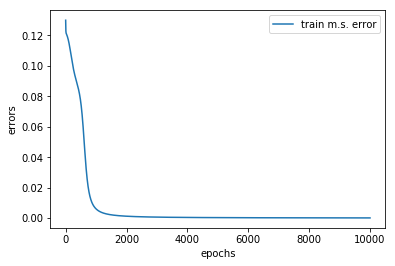

In [790]:
mlp_1.plot_error()

### Predictions
The following are the predicitons by the trained network

In [791]:
[(x, mlp_1.predict(x)[0]) for x in X]

[([0, 0], 0.01541186757813418),
 ([0, 1], 0.983721913538002),
 ([1, 0], 0.9837203257493947),
 ([1, 1], 0.02011245543754397)]

In [ ]:
mlp_2 = MLP()
mlp_2.initialize(NI=2, NH=2, NO=1, activation_h=tanh, activation_o=sigmoid)
mlp_2.train(X, y, n_epochs=10000, batch_size=2, learning_rate=0.5)


Plot of average mean squared error for each input
in the train set


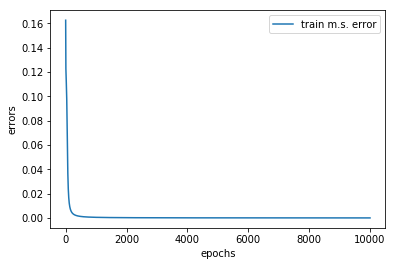

In [754]:
mlp_2.plot_error()

In [755]:
[(x, mlp_2.predict(x)[0]) for x in X]

[([0, 0], 0.010312754901002188),
 ([0, 1], 0.9923122519457148),
 ([1, 0], 0.9923151330238322),
 ([1, 1], 0.010583417455724739)]

In [ ]:
mlp_3 = MLP()
mlp_3.initialize(NI=2, NH=2, NO=1, activation_h=tanh, activation_o=tanh)
mlp_3.train(X, y, n_epochs=10000, batch_size=2, learning_rate=0.5)


Plot of average mean squared error for each input
in the train set


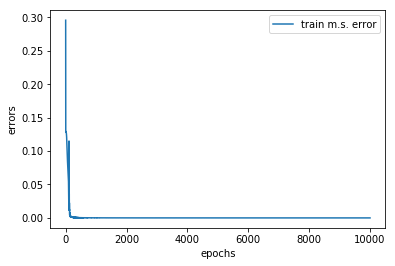

In [796]:
mlp_3.plot_error()

In [797]:
[(x, mlp_3.predict(x)[0]) for x in X]

[([0, 0], 0.006654644229785989),
 ([0, 1], 0.995006821534851),
 ([1, 0], 0.9953287225503522),
 ([1, 1], 0.008022292893288464)]

In [ ]:
mlp_4 = MLP()
mlp_4.initialize(NI=2, NH=2, NO=1, activation_h=tanh, activation_o=linear)
mlp_4.train(X, y, n_epochs=10000, batch_size=2, learning_rate=0.05)


Plot of average mean squared error for each input
in the train set


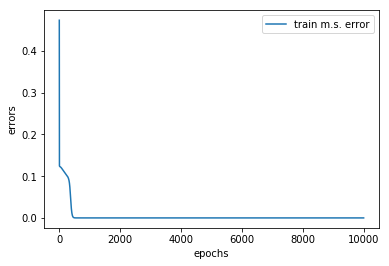

In [760]:
mlp_4.plot_error()

In [761]:
[(x, mlp_4.predict(x)[0]) for x in X]

[([0, 0], -3.1086244689504383e-15),
 ([0, 1], 1.0000000000000004),
 ([1, 0], 0.9999999999999989),
 ([1, 1], 2.6645352591003757e-15)]

In [ ]:
mlp_5 = MLP()
mlp_5.initialize(NI=2, NH=2, NO=1, activation_h=sigmoid, activation_o=linear)
mlp_5.train(X, y, n_epochs=10000, batch_size=2, learning_rate=0.05)


Plot of average mean squared error for each input
in the train set


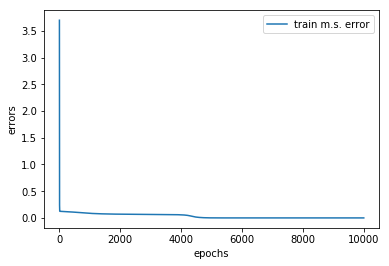

In [764]:
mlp_5.plot_error()

In [765]:
[(x, mlp_5.predict(x)[0]) for x in X]

[([0, 0], 2.256230757780031e-10),
 ([0, 1], 0.9999999996665863),
 ([1, 0], 0.9999999996485012),
 ([1, 1], 5.069926700684846e-10)]

In [ ]:
mlp_6 = MLP()
mlp_6.initialize(NI=2, NH=2, NO=1, activation_h=sigmoid, activation_o=linear)
mlp_6.train(X, y, n_epochs=10000, batch_size=2, learning_rate=0.1)


Plot of average mean squared error for each input
in the train set


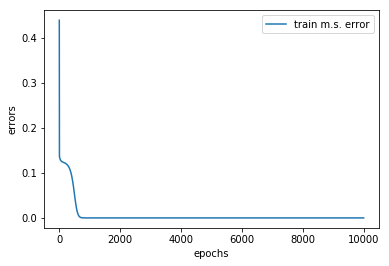

In [767]:
mlp_6.plot_error()

In [768]:
[(x, mlp_6.predict(x)[0]) for x in X]

[([0, 0], 2.1094237467877974e-15),
 ([0, 1], 0.9999999999999963),
 ([1, 0], 0.9999999999999963),
 ([1, 1], 4.3298697960381105e-15)]

## Sin Approximation Problem
A training set of 200 vectors (each one consisting of 4 random numbers in $]-1, 1[$ ) is generated. For each of this vectors, a label is generated as $sin(v_0-v_1+v_2-v_3)$. Of the 200 samples, 150 are used for trainig and 50 for testing. The networks seem to learn without problems, with a perfect generalization on the test samples. Compared with the XOR problem, in order to approximate this function through the mlp it is necessary to set a smaller learning rate, otherwise the gradients explode very quickly, or the values of the loss oscillate too much, symptom that the network is not learning.  
The testes topology has 4 input units, 5 hidden units and 1 output unit.

In [769]:
X_sin = [np.random.randn(1, 4)[0] for i in range(200)]
y_sin = [[math.sin(v[0]-v[1]+v[2]-v[3])] for v in X_sin]


X_train, y_train, X_test, y_test = X_sin[:150], y_sin[:150], X_sin[150:], y_sin[150:]

In [ ]:
mlp_7 = MLP()
mlp_7.initialize(NI=4, NH=5, NO=1, activation_h=sigmoid, activation_o=linear)
mlp_7.train(X_train, y_train, n_epochs=10000, batch_size=50, learning_rate=0.0025, X_test=X_test, y_test=y_test)


Plot of average mean squared error for each input
in the train set and test set:


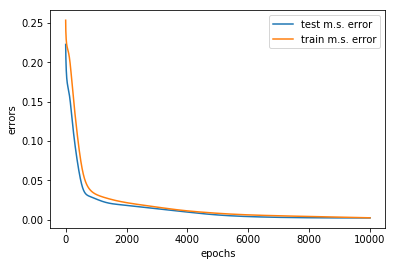

In [771]:
mlp_7.plot_error()

### Test-Set Predictions
The following cell shows the predictions on the test set

In [772]:
_ = [print("Prediction: %.4f Target: %.4f"%(mlp_7.predict(v[0])[0], v[1][0])) for v in zip(X_test, y_test)]

Prediction: -0.1310 Target: -0.0572
Prediction: -0.1221 Target: -0.1022
Prediction: 0.8772 Target: 0.8603
Prediction: -0.2874 Target: -0.2911
Prediction: -0.7537 Target: -0.7494
Prediction: 0.9381 Target: 0.9735
Prediction: 0.2202 Target: 0.2750
Prediction: -0.9168 Target: -0.9220
Prediction: 0.9946 Target: 0.9731
Prediction: -0.6770 Target: -0.6503
Prediction: 0.2511 Target: 0.2412
Prediction: -0.9348 Target: -0.9492
Prediction: -0.6656 Target: -0.6519
Prediction: -0.5011 Target: -0.9311
Prediction: -0.5965 Target: -0.5879
Prediction: -0.9649 Target: -0.9688
Prediction: -0.4407 Target: -0.4187
Prediction: -0.0161 Target: 0.0031
Prediction: -0.4242 Target: -0.4095
Prediction: 0.9091 Target: 0.9028
Prediction: 0.7579 Target: 0.7551
Prediction: -0.5827 Target: -0.5650
Prediction: 0.8060 Target: 0.7895
Prediction: -0.1426 Target: -0.1246
Prediction: -0.6016 Target: -0.5734
Prediction: 0.2619 Target: 0.2829
Prediction: 0.9948 Target: 0.9819
Prediction: 0.8775 Target: 0.8470
Prediction: -0.

In [ ]:
mlp_8 = MLP()
mlp_8.initialize(NI=4, NH=5, NO=1, activation_h=tanh, activation_o=linear)
mlp_8.train(X_train, y_train, n_epochs=10000, batch_size=50, learning_rate=0.0025, X_test=X_test, y_test=y_test)


Plot of average mean squared error for each input
in the train set and test set:


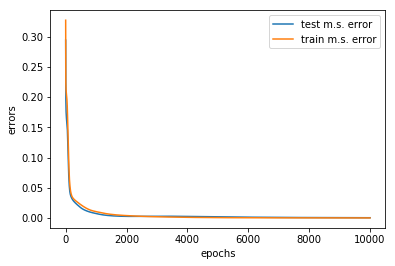

In [781]:
mlp_8.plot_error()

In [782]:
_ = [print("Prediction: %.4f Target: %.4f"%(mlp_8.predict(v[0])[0], v[1][0])) for v in zip(X_test, y_test)]

Prediction: -0.0885 Target: -0.0572
Prediction: -0.0928 Target: -0.1022
Prediction: 0.8896 Target: 0.8603
Prediction: -0.2870 Target: -0.2911
Prediction: -0.7435 Target: -0.7494
Prediction: 0.9798 Target: 0.9735
Prediction: 0.2693 Target: 0.2750
Prediction: -0.9295 Target: -0.9220
Prediction: 0.9651 Target: 0.9731
Prediction: -0.6508 Target: -0.6503
Prediction: 0.2455 Target: 0.2412
Prediction: -0.9523 Target: -0.9492
Prediction: -0.6454 Target: -0.6519
Prediction: -0.7522 Target: -0.9311
Prediction: -0.5848 Target: -0.5879
Prediction: -0.9768 Target: -0.9688
Prediction: -0.4113 Target: -0.4187
Prediction: 0.0118 Target: 0.0031
Prediction: -0.3966 Target: -0.4095
Prediction: 0.8977 Target: 0.9028
Prediction: 0.7818 Target: 0.7551
Prediction: -0.5613 Target: -0.5650
Prediction: 0.7825 Target: 0.7895
Prediction: -0.1182 Target: -0.1246
Prediction: -0.5689 Target: -0.5734
Prediction: 0.2796 Target: 0.2829
Prediction: 0.9970 Target: 0.9819
Prediction: 0.8417 Target: 0.8470
Prediction: -0.0

In [ ]:
# Test with batch_size = 150

mlp_9 = MLP()
mlp_9.initialize(NI=4, NH=5, NO=1, activation_h=tanh, activation_o=linear)
mlp_9.train(X_train, y_train, n_epochs=10000, batch_size=150, learning_rate=0.0025, X_test=X_test, y_test=y_test)


Plot of average mean squared error for each input
in the train set and test set:


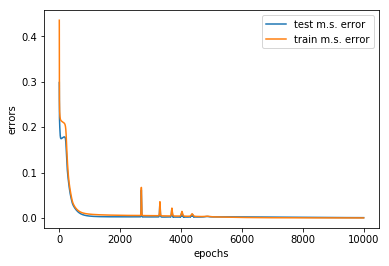

In [784]:
mlp_9.plot_error()

In [785]:
_ = [print("Prediction: %.4f Target: %.4f"%(mlp_9.predict(v[0])[0], v[1][0])) for v in zip(X_test, y_test)]

Prediction: -0.0995 Target: -0.0572
Prediction: -0.0910 Target: -0.1022
Prediction: 0.8909 Target: 0.8603
Prediction: -0.2962 Target: -0.2911
Prediction: -0.7431 Target: -0.7494
Prediction: 0.9748 Target: 0.9735
Prediction: 0.2749 Target: 0.2750
Prediction: -0.9307 Target: -0.9220
Prediction: 0.9607 Target: 0.9731
Prediction: -0.6550 Target: -0.6503
Prediction: 0.2496 Target: 0.2412
Prediction: -0.9416 Target: -0.9492
Prediction: -0.6458 Target: -0.6519
Prediction: -0.6840 Target: -0.9311
Prediction: -0.5861 Target: -0.5879
Prediction: -0.9659 Target: -0.9688
Prediction: -0.4204 Target: -0.4187
Prediction: 0.0146 Target: 0.0031
Prediction: -0.4182 Target: -0.4095
Prediction: 0.8890 Target: 0.9028
Prediction: 0.7869 Target: 0.7551
Prediction: -0.5632 Target: -0.5650
Prediction: 0.7858 Target: 0.7895
Prediction: -0.1197 Target: -0.1246
Prediction: -0.5737 Target: -0.5734
Prediction: 0.2787 Target: 0.2829
Prediction: 0.9876 Target: 0.9819
Prediction: 0.8365 Target: 0.8470
Prediction: -0.0

In [ ]:
# Test with batch_size = 1

mlp_10 = MLP()
mlp_10.initialize(NI=4, NH=5, NO=1, activation_h=tanh, activation_o=linear)
mlp_10.train(X_train, y_train, n_epochs=10000, batch_size=1, learning_rate=0.0025, X_test=X_test, y_test=y_test)


Plot of average mean squared error for each input
in the train set and test set:


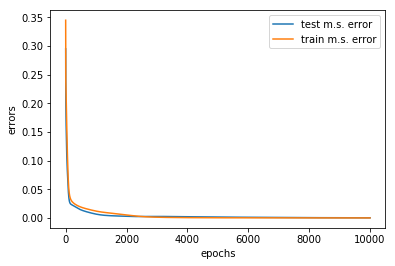

In [787]:
mlp_10.plot_error()

In [788]:
_ = [print("Prediction: %.4f Target: %.4f"%(mlp_10.predict(v[0])[0], v[1][0])) for v in zip(X_test, y_test)]

Prediction: -0.0717 Target: -0.0572
Prediction: -0.0854 Target: -0.1022
Prediction: 0.8673 Target: 0.8603
Prediction: -0.2920 Target: -0.2911
Prediction: -0.7502 Target: -0.7494
Prediction: 0.9732 Target: 0.9735
Prediction: 0.2803 Target: 0.2750
Prediction: -0.9236 Target: -0.9220
Prediction: 0.9755 Target: 0.9731
Prediction: -0.6481 Target: -0.6503
Prediction: 0.2415 Target: 0.2412
Prediction: -0.9521 Target: -0.9492
Prediction: -0.6503 Target: -0.6519
Prediction: -0.7862 Target: -0.9311
Prediction: -0.5852 Target: -0.5879
Prediction: -0.9678 Target: -0.9688
Prediction: -0.4188 Target: -0.4187
Prediction: 0.0022 Target: 0.0031
Prediction: -0.4026 Target: -0.4095
Prediction: 0.8997 Target: 0.9028
Prediction: 0.7645 Target: 0.7551
Prediction: -0.5626 Target: -0.5650
Prediction: 0.7904 Target: 0.7895
Prediction: -0.1255 Target: -0.1246
Prediction: -0.5757 Target: -0.5734
Prediction: 0.2864 Target: 0.2829
Prediction: 0.9838 Target: 0.9819
Prediction: 0.8453 Target: 0.8470
Prediction: -0.0

## Uci Letters Recognition Problem
Problem of recognizing written letters based on some visual-numerical characteristics. The full dataset consists of 20000 letters, 16000 of wich are used for the network training. In order to perform training in a more efficient way, the inputs are scaled through a StandardScaler, provided by Sklearn, and a One-Hot-Encoder is used in order to encode letters as (one-hot) binary arrays.  

Differently from the other (much simpler) problems, this network requires a much bigger number of parameters (so a bigger hidden layer). Tests carried on with a smaller hidden layer (10-20 units) required a very long time to optimize the cost function; the provided architecture (40 hidden units) takes more time per epoch for the learning, but the optimization is orders of magnitudes faster. On the output layer, the sigmoid function is used in order to estimate the probability for each specific class; on the hidden layer the tanh activation is used. After few epochs (around 30), the network is able to predict correectly thee labels of the train set with a probability around 90-92%, while the prediction on the test set reach an accuracy of roughly 85%. 

After 50 epochs, the network starts to overfit (the training loss decreases, while the test loss increases), so the training is stopped.

In [518]:
letters_dataset = pd.read_csv("letter-recognition.data")
X_letters, y_letters = letters_dataset.values[:, 1:], letters_dataset.values[:, :1]

In [519]:
encoder= OneHotEncoder(sparse=False)
y_letters = encoder.fit_transform(y_letters)

In [520]:
scaler = StandardScaler()
X_letters = scaler.fit_transform(X_letters)

/Users/giovanniciampi/anaconda3/envs/lstm_test/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/giovanniciampi/anaconda3/envs/lstm_test/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [521]:
X_letters_train, y_letters_train = X_letters[:16000], y_letters[:16000]

In [522]:
X_letters_test, y_letters_test = X_letters[16000:], y_letters[16000:]

Epoch = 1 MSError= 4439.464587538895
Epoch = 2 MSError= 2697.9050869954326
Epoch = 3 MSError= 2341.7185500077376
Epoch = 4 MSError= 2169.029625717901
Epoch = 5 MSError= 2067.067940163161
Epoch = 6 MSError= 1980.5539467402782
Epoch = 7 MSError= 1912.02393684197
Epoch = 8 MSError= 1863.9706975305016
Epoch = 9 MSError= 1825.4179291554804
Epoch = 10 MSError= 1792.5180682348641
Epoch = 11 MSError= 1764.2301280248682
Epoch = 12 MSError= 1740.1090535481428
Epoch = 13 MSError= 1717.0880126383681
Epoch = 14 MSError= 1693.5466247420904
Epoch = 15 MSError= 1672.8472998086127
Epoch = 16 MSError= 1655.3415247859932
Epoch = 17 MSError= 1639.7844668497607
Epoch = 18 MSError= 1627.6669153589296
Epoch = 19 MSError= 1616.800803809947
Epoch = 20 MSError= 1606.9139879045454

Plot of average mean squared error for each input
in the train set and test set:


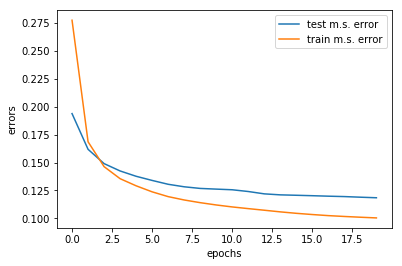

In [636]:
mlp_14 = MLP()
mlp_14.initialize(NI=16, NH=40, NO=26, activation_h=tanh, activation_o=sigmoid)
mlp_14.train(X_letters_train, y_letters_train, n_epochs=20, batch_size=50, learning_rate=0.1, X_test=X_letters_test, y_test=y_letters_test)

Epoch = 21 MSError= 1597.3973206903945
Epoch = 22 MSError= 1588.956426043098
Epoch = 23 MSError= 1581.844207871976
Epoch = 24 MSError= 1575.5779957657269
Epoch = 25 MSError= 1568.322750171903
Epoch = 26 MSError= 1560.7696142231016
Epoch = 27 MSError= 1554.2317544337527
Epoch = 28 MSError= 1548.9323902459414
Epoch = 29 MSError= 1544.027236495132
Epoch = 30 MSError= 1538.651143356069

Plot of average mean squared error for each input
in the train set and test set:


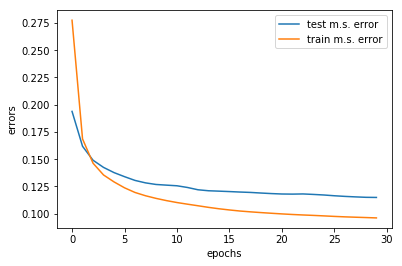

In [639]:
mlp_14.train(X_letters_train, y_letters_train, n_epochs=10, batch_size=50, learning_rate=0.1, X_test=X_letters_test, y_test=y_letters_test)
#

Epoch = 31 MSError= 1533.4968342369107
Epoch = 32 MSError= 1528.438304588581
Epoch = 33 MSError= 1525.1140270583899
Epoch = 34 MSError= 1522.121127229223
Epoch = 35 MSError= 1518.6661751516149
Epoch = 36 MSError= 1513.9170127613804
Epoch = 37 MSError= 1509.875994419719
Epoch = 38 MSError= 1506.7536348073106
Epoch = 39 MSError= 1502.6837683871877
Epoch = 40 MSError= 1498.3543323535707
Epoch = 41 MSError= 1494.6385576825894
Epoch = 42 MSError= 1491.2493373945413
Epoch = 43 MSError= 1488.2639619503673
Epoch = 44 MSError= 1485.5697033757926
Epoch = 45 MSError= 1481.4736354039258
Epoch = 46 MSError= 1479.1500235131311
Epoch = 47 MSError= 1476.5205270156364
Epoch = 48 MSError= 1474.0635453156513
Epoch = 49 MSError= 1472.2223281998133
Epoch = 50 MSError= 1470.2159692425298

Plot of average mean squared error for each input
in the train set and test set:


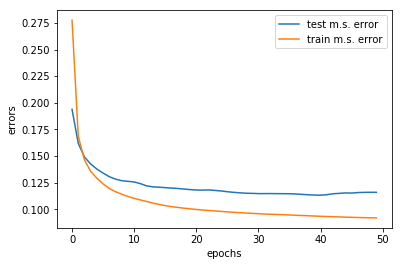

In [682]:
mlp_14.train(X_letters_train, y_letters_train, n_epochs=20, batch_size=50, learning_rate=0.1, X_test=X_letters_test, y_test=y_letters_test)
#

### Predictions on random items of the test set
Just execute the following cell

In [698]:
index = np.random.randint(3999)
prediction_raw = mlp_14.predict(X_letters_test[index]).reshape(1, -1)
prediction = encoder.inverse_transform(prediction_raw)
ground_truth = encoder.inverse_transform(y_letters_test[index].reshape(1, -1))
print(prediction_raw)
print("y = "+str(prediction[0][0]))
print("t = "+str(ground_truth[0][0]))

[[2.19623555e-08 2.27990163e-07 8.18570334e-06 7.07443265e-08
  3.52897910e-02 3.62159684e-06 2.93791671e-04 1.48494771e-07
  1.33171737e-08 1.21082458e-06 5.40548695e-07 8.12251870e-04
  1.75519628e-10 3.74215116e-12 9.60677799e-14 5.40159107e-10
  1.54642746e-08 8.30617661e-05 1.02514524e-03 1.65905924e-07
  2.70617466e-07 1.48250296e-10 8.18417948e-18 7.21560691e-04
  9.55811771e-13 9.20738040e-01]]
y = Z
t = Z


### Test-Set Accuracy

In [749]:
n_er = 0
for item in zip(X_letters_test, y_letters_test):
    prediction_raw = mlp_14.predict(item[0]).reshape(1, -1)
    prediction = encoder.inverse_transform(prediction_raw)
    ground_truth = encoder.inverse_transform(item[1].reshape(1, -1))
    if prediction != ground_truth:
        n_er += 1
print("Test-Set Accuracy = "+str(1-(n_er/float(len(X_letters_test)))))

Test-Set Accuracy = 0.8412103025756439
